# Modellbildung

In [1]:
import sys
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from IPython.display import display, Image
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp

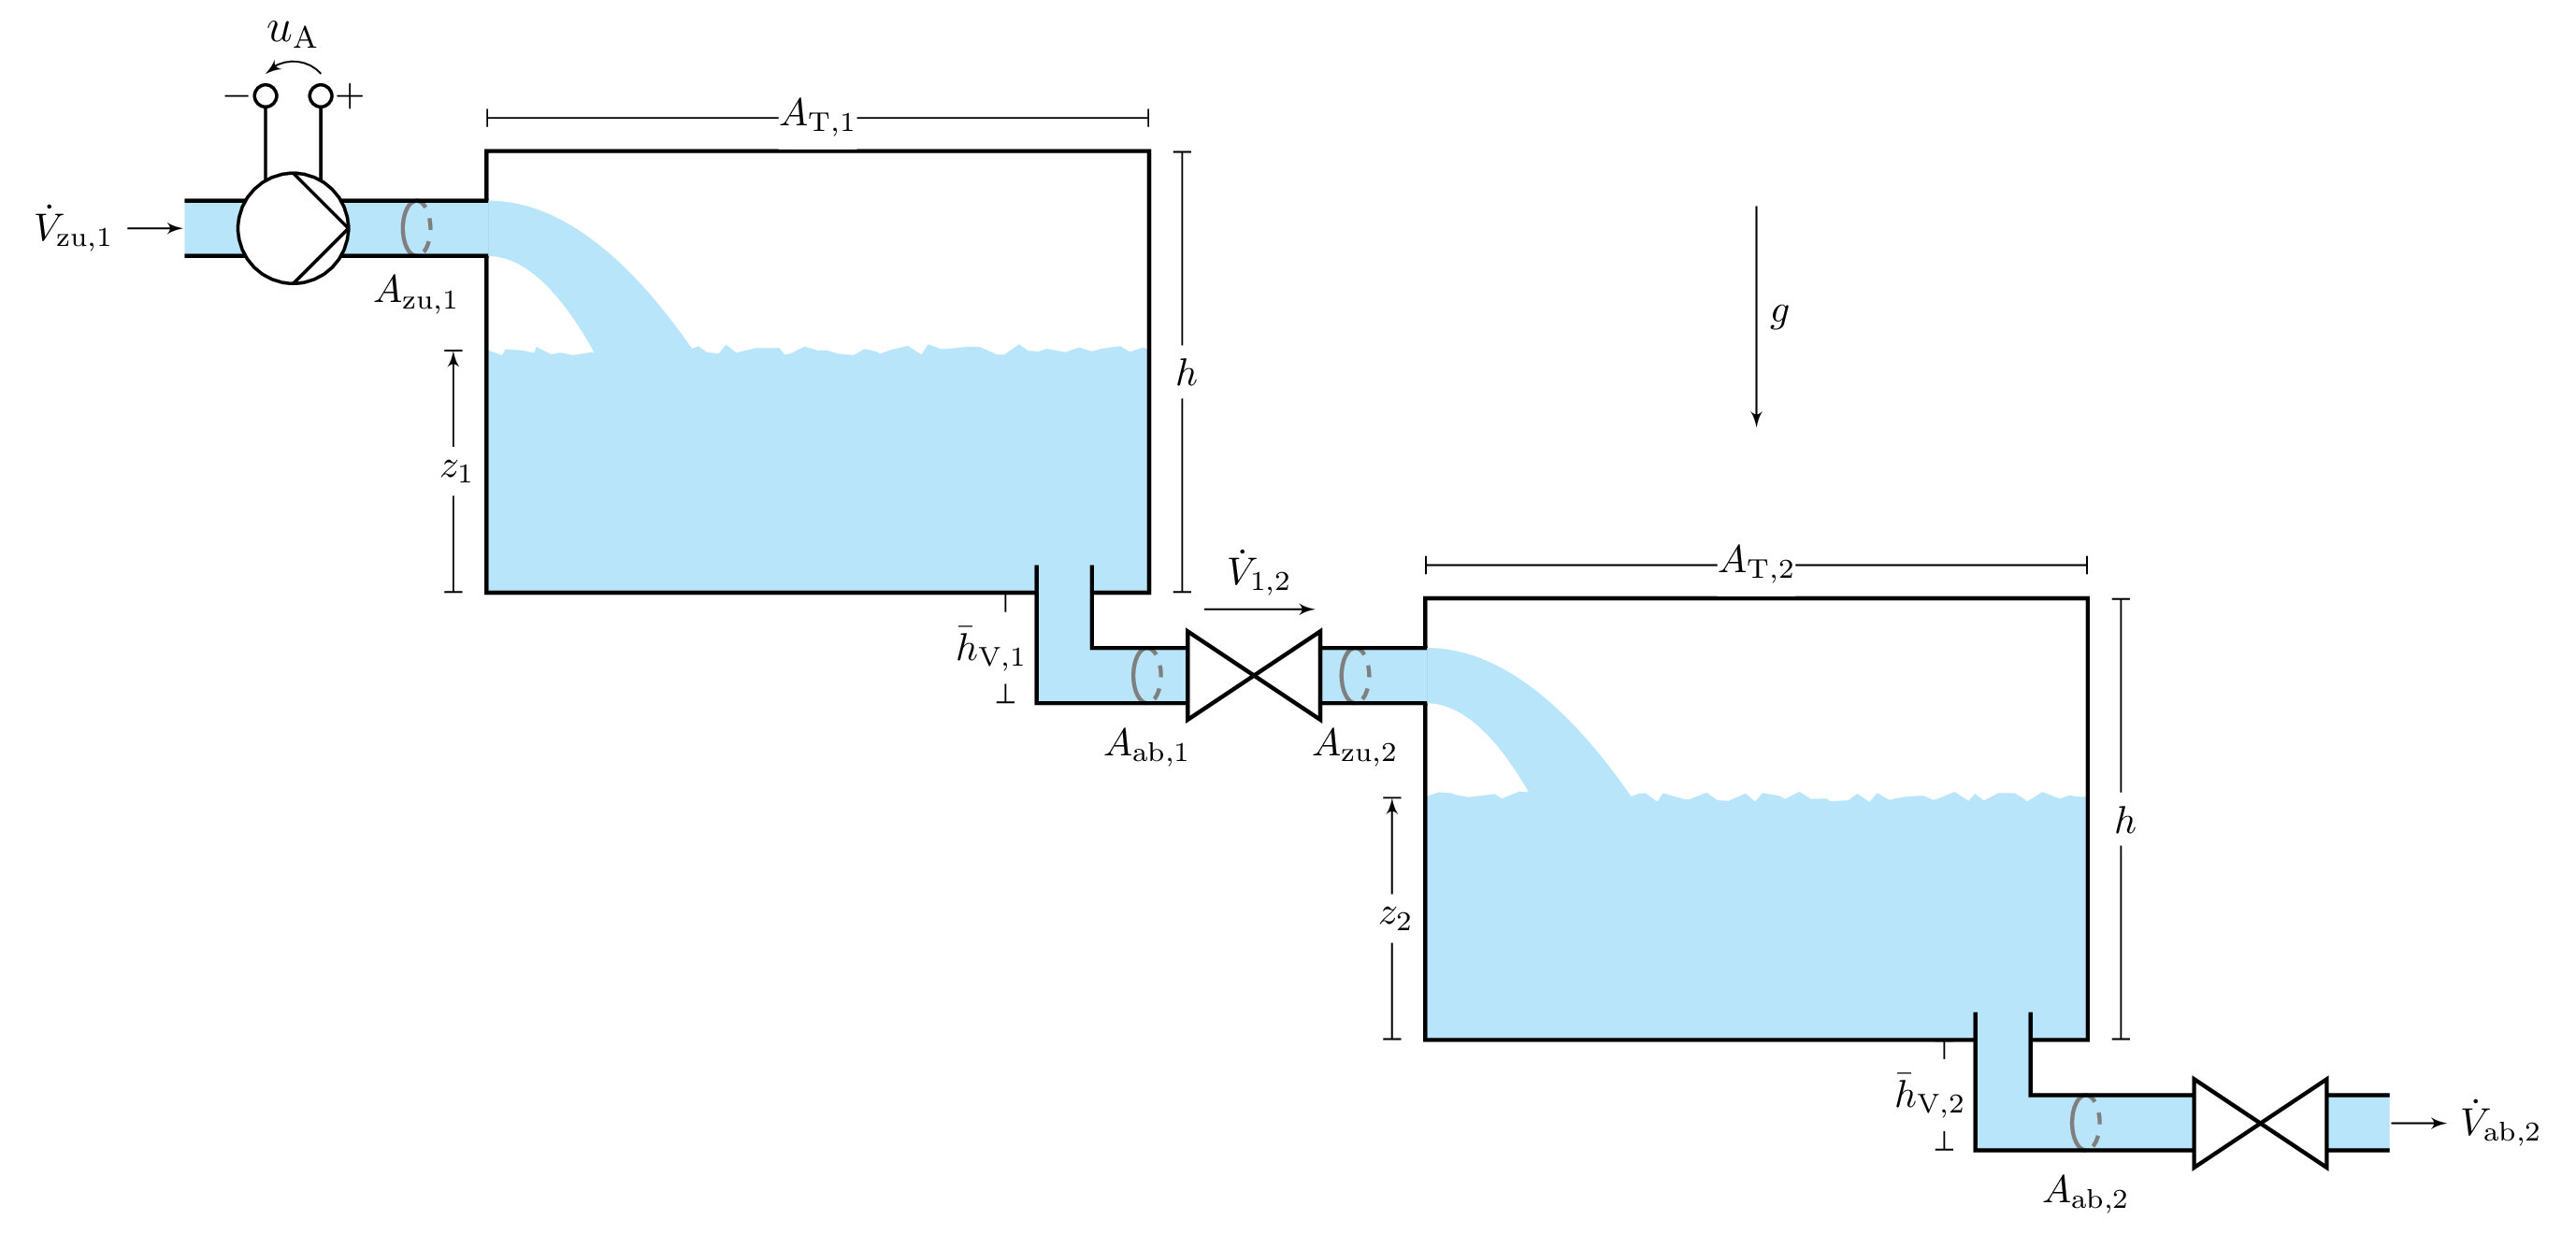

In [2]:
imag = Image("images/zweitank.png", width=600)
display(imag)

Ziel ist die Modellierung des Eingangs-Ausgangsverhaltens des bekannten 2-Tanksystems.
Durch die Modellierung aus der Übung ist bekannt, dass es sich bei dem linearisierten Modell um ein System zweiter Ordnung
\begin{align*}
    T_1T_2\ddot{z}_2(t) + (T_1 + T_2)\dot{z}_2(t) + z_2(t) & = K_\text{P} u(t)
\end{align*}
handelt.

Nachfolgend sollen die drei parameterierte Varianten des Modells ermittelt und simuliert werden:

1. auf Basis der physikalischen Parameter,
2. ausgehend von der aufgenommenen Sprungantwort für das Gesamtsystem sind die Parameter zu bestimmen sowie
3. Seperierung des Systems in zwei Einzeltanksysteme in Systeme erster Ordnung und Bestimmung der Parameter auf Basis der aufgenommenen Sprungangworten für die beiden Teilsysteme

In [3]:
aufbau = 1

### Messdaten einlesen

In [4]:
if aufbau == 1:
    messungTank1Tank2 = pd.read_csv('aufbau1_tank1tank2.csv')
    messungTank2 = pd.read_csv('aufbau1_tank2.csv')
elif aufbau == 2:
    messungTank1Tank2 = pd.read_csv('aufbau2_tank1tank2.csv')
    messungTank2 = pd.read_csv('aufbau2_tank2.csv')

### 1. Physikalische Parameter

Bestimmen Sie die Parameter für das linearisierte System auf Basis der gegebenen physikalischen Parameter des Versuchstandes für die Ruhelage $\bar{u} = 9\, \mathrm{V}$.

In [5]:
if aufbau == 1:
    Kp_analytic = 0.1384482
    T1_analytic = 32.993533
    T2_analytic = 65.106089
elif aufbau == 2:
    Kp_analytic = 0.072643
    T1_analytic = 36.048596
    T2_analytic = 60.153381
    
display(Markdown(
   rf"""
$K_\text{{p}} = {Kp_analytic}$

$T_1 = {T1_analytic}$

$T_2 = {T2_analytic}$
"""))

pAnalytic = [Kp_analytic, T1_analytic, T2_analytic]


$K_\text{p} = 0.1384482$

$T_1 = 32.993533$

$T_2 = 65.106089$


### 2. Parameter des messtechnisch erfassten PT$_2$-Elements

Um die Parameter zu bestimmen, wird die analytische Lösung des Systems zweiter Ordnung für einen Einheitssprung $t \mapsto \sigma(t)$ als Eingang verwendet:
\begin{align*}
z_2(t) = K_\text{P}\left(1 - \frac{1}{T_1-T_2}\left(T_1 e^{-\frac{t}{T_1}} - T_2 e^{-\frac{t}{T_2}}\right)\right)
\end{align*}

Die Parameter $T_1$, $T_2$ und $K$ werden unter Verwendung der vorangegangenen Lösung mittels eines Optimierungsverfahrens bestimmt.

In [6]:
def pt2Analytic(t, Kp, T1, T2):
    val = Kp * (1 - 1 / (T1 - T2) * (T1 * np.exp(-t/T1) - T2 * np.exp(-t/T2)))
    for i in range(len(val)):
        if not math.isfinite(val[i]):
            print(val[i])
            val[i] = 0
    return val

In [7]:
xData = messungTank1Tank2['time']
yData = messungTank1Tank2['HeightT2']

# errorcorrect measured data (in HeightT2 some values are nan)
for i in range(len(yData)):
   if not math.isfinite(yData[i]):
      try:
         # if value is nan, use mean of prev and next value
         yData[i] = (yData[i-1] + yData[i+1]) /2
      except: 
         print('implement more ')

# Delete part of the first second in which the pump voltage ramps up
time = 0.2
for i in range(len(xData)):
   if xData[i] >= time:
      # delete first entries, adapt indexes, set starttime = 0
      xData = xData.iloc[i:]
      xData.index -= i
      xData -= time
      # also delete corresponding height entries
      yData = yData.iloc[i:]
      yData.index -= i
      break

pOpt, _ = curve_fit(pt2Analytic, xdata=xData, ydata=yData, p0=pAnalytic)

Kp_pt2 = pOpt[0]
T1_pt2 = min(pOpt[1], pOpt[2])
T2_pt2 = max(pOpt[1], pOpt[2])

display(Markdown(
   rf"""
$K_\text{{p}} = {Kp_pt2}$

$T_1 = {T1_pt2}$

$T_2 = {T2_pt2}$
"""))


$K_\text{p} = 0.13275736157087772$

$T_1 = 46.930754374604625$

$T_2 = 46.93112066644971$


### 3.  Parameter der messtechnisch erfassten seriell verschalteten PT$_1$-Elemente

Durch Aufspaltung des Systems in zwei Einzelelemente, die die Form eines Systems erster Ordnung annehmen, können durch Auswerten der Sprungantwort
\begin{align}
    z_i(t) & = K_i \left(1 - e^{-\frac{t}{T_i}}\right), & i & = 1,2
\end{align}
die Zeitkonstanten bestimmt werden.

In [8]:
def pt1Analytic(t, Kp, T1):
    return Kp * (1 - np.exp(-t / T1))

#### Tank 1

In [9]:
xDataT1 = messungTank1Tank2['time']
yDataT1 = messungTank1Tank2['HeightT1']

# curvefitting and printing the result
pOpt, _ = curve_fit(pt1Analytic, xdata=xDataT1, ydata=yDataT1)

# storing results
K1_1_pt1 = pOpt[0]
T1_1_pt1 = pOpt[1]

display(Markdown(
rf"""
$K_1 = {K1_1_pt1}$

$T_1 = {T1_1_pt1}$
"""))


$K_1 = 0.0256249651328918$

$T_1 = 39.614841566612256$


#### Tank 2

In [10]:
xDataT2 = messungTank2['time']
yDataT2 = messungTank2['HeightT2']

pOpt, _ = curve_fit(pt1Analytic, xdata=xDataT2, ydata=yDataT2)

# storing results
K2_2_pt1 = pOpt[0]
T2_2_pt1 = pOpt[1]

display(Markdown(
   rf"""
$K_2 = {K2_2_pt1}$

$T_2 = {T2_2_pt1}$
"""))


$K_2 = 0.13160834663644597$

$T_2 = 76.60863730105318$


In [11]:
Kp_pt1 = K2_2_pt1
T1_pt1 = min(T1_1_pt1, T2_2_pt1)
T2_pt1 = max(T1_1_pt1, T2_2_pt1)

display(Markdown(
    rf"""
$K_\text{{p}} = {Kp_pt1}$

$T_1 = {T1_pt1}$

$T_2 = {T2_pt1}$
"""))


$K_\text{p} = 0.13160834663644597$

$T_1 = 39.614841566612256$

$T_2 = 76.60863730105318$


## Vergleich aller Modelle

In [12]:
params = {
    'T1': [round(T1_analytic, 5), round(T1_pt2, 5), round(T1_pt1, 5)],
    'T2': [round(T2_analytic, 5), round(T2_pt2, 5), round(T2_pt1, 5)],
    'Kp': [round(Kp_analytic, 5), round(Kp_pt2, 5), round(Kp_pt1, 5)],
}
print ("{:<5} {:<11} {:<9} {:<11}".format(' ','analytisch','PT2','PT1'))
for name, values in params.items():
    s1, s2, s3 = values
    print ("{:<5} {:<11} {:<9} {:<11}".format(name, s1, s2, s3))

      analytisch  PT2       PT1        
T1    32.99353    46.93075  39.61484   
T2    65.10609    46.93112  76.60864   
Kp    0.13845     0.13276   0.13161    


In [13]:
def linSys(t, x, u, A, B):
    return A.dot(x) +  B.dot(u)

In [14]:
A_analytic = np.array([[0, 1],
                       [-1 / (T1_analytic * T2_analytic), - (T1_analytic + T2_analytic) / (T1_analytic * T2_analytic)]])
B_analytic = np.array([[0],
                       [Kp_analytic / (T1_analytic * T2_analytic)]])

A_pt2 = np.array([[0, 1],
                  [-1 / (T1_pt2 * T2_pt2), - (T1_pt2 + T2_pt2) / (T1_pt2 * T2_pt2)]])
B_pt2 = np.array([[0],
                  [Kp_pt2 / (T1_pt2 * T2_pt2)]])

A_pt1 = np.array([[0, 1],
                  [-1 / (T1_pt1 * T2_pt1), - (T1_pt1 + T2_pt1) / (T1_pt1 * T2_pt1)]])
B_pt1 = np.array([[0],
                  [Kp_pt1 / (T1_pt1 * T2_pt1)]])

In [15]:
timeDom = np.linspace(0, len(messungTank1Tank2['HeightT2']), len(messungTank1Tank2['HeightT2'])) / 10
x0 = [0, 0]
u = [1]

solAnalytic = solve_ivp(linSys, [timeDom[0], timeDom[-1]], x0, t_eval=timeDom, args=(u, A_analytic, B_analytic))
solPT2 = solve_ivp(linSys, [timeDom[0], timeDom[-1]], x0, t_eval=timeDom, args=(u, A_pt2, B_pt2))
solPT1 = solve_ivp(linSys, [timeDom[0], timeDom[-1]], x0, t_eval=timeDom, args=(u, A_pt1, B_pt1))

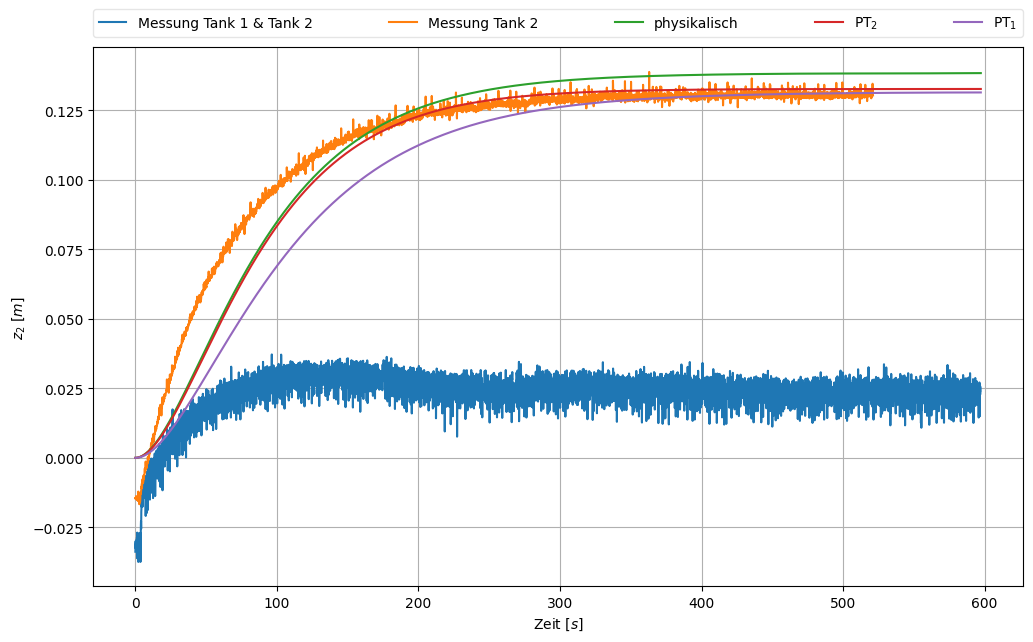

In [16]:
plt.close()

fig1, axes10 = plt.subplots(1, 1, figsize=(12,7))

axes10.plot(messungTank1Tank2['time'], messungTank1Tank2['HeightT1'], label=r'Messung Tank 1 & Tank 2')
axes10.plot(messungTank2['time'], messungTank2['HeightT2'], label=r'Messung Tank 2')
axes10.plot(timeDom, solAnalytic.y[0], label='physikalisch')
axes10.plot(timeDom, solPT2.y[0], label=r'PT$_2$')
axes10.plot(timeDom, solPT1.y[0], label=r'PT$_1$')

axes10.set_ylabel(r'$z_2$ [$m$]')
axes10.set_xlabel(r'Zeit [$s$]')

handlesAx1, labelsAx1 = axes10.get_legend_handles_labels()
axes10.legend([handle for i, handle in enumerate(handlesAx1)],
              [label for i, label in enumerate(labelsAx1)],
              bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
              ncol=9, mode="expand", borderaxespad=0., framealpha=0.5)

axes10.grid()
plt.show()